# DECODING IN RPI

In [59]:
import os.path as osp
import pandas as pd
import numpy as np
from utils.basics import FB_400ROI_ATLAS_NAME as ATLAS_NAME
from utils.basics import ATLASES_DIR, RESOURCES_NBS_DIR,RESOURCES_NIMARE_DIR
from utils.plotting import create_graph_from_matrix
from nilearn import masking
from nilearn.plotting import plot_stat_map, plot_roi
from nilearn.image import load_img
import subprocess

from wordcloud import WordCloud, STOPWORDS
import wordcloud
print('wordcloud version: %s' % str(wordcloud.__version__))
from nimare.dataset import Dataset as nimare_dataset
from matplotlib.colors import LinearSegmentedColormap
from nimare.decode import discrete
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt

wordcloud version: 1.8.2.2


In [55]:
def my_orange_color_func(dictionary):
    def my_orange_color_func_inner(word, font_size, position, orientation, random_state=None, **kwargs):
        freq_as_int = int(dictionary[word])
        color_list = sns.color_palette('Oranges',100).as_hex()
        return color_list[freq_as_int]
    return my_orange_color_func_inner
def my_blue_color_func(dictionary):
    def my_blue_color_func_inner(word, font_size, position, orientation, random_state=None, **kwargs):
        freq_as_int = int(dictionary[word])
        color_list = sns.color_palette('Blues',100).as_hex()
        return color_list[freq_as_int]
    return my_blue_color_func_inner

In [2]:
VOCAB                = 'LDA50'
NBS_THRESHOLD        = 'NBS_3p1'
VOCAB_DIR            = osp.join(RESOURCES_NIMARE_DIR,VOCAB)
METAMAPS_RPI_DIR     = osp.join(VOCAB_DIR,"meta-analyses-RPI")  # where to save meta-analysis maps

# 2. Extract ROIs with highest degree for both NBS contrasts

# 2.1. Load Atlas Information so that we can annotate Pandas Dataframes

In [3]:
ATLASINFO_PATH = osp.join(ATLASES_DIR,ATLAS_NAME,'{ATLAS_NAME}.roi_info.csv'.format(ATLAS_NAME=ATLAS_NAME))
roi_info       = pd.read_csv(ATLASINFO_PATH)

## 2.2. Load NBS Results

In [4]:
NBS_constrasts = {}

Load the connections that are significantly stronger for the contrast: $$Image-Pos-Others > Surr-Neg-Self$$

In [6]:
#data_f1GTf2 = np.loadtxt(osp.join(RESOURCES_NBS_DIR,f'{ATLAS_NAME}/NBS_CL02_Results/NBS_CL02_Image-Pos-Others_gt_Surr-Neg-Self.edge'))
data_f1GTf2 = np.loadtxt(osp.join(RESOURCES_NBS_DIR,ATLAS_NAME,'All_Scans','NBS_CL02_Results',NBS_THRESHOLD,'NBS_CL02_Image-Pos-Others_gt_Surr-Neg-Self.edge'))
NBS_constrasts['f1GTf2'] = pd.DataFrame(data_f1GTf2,
                           index   = roi_info.set_index(['Hemisphere','Network','ROI_Name','ROI_ID','RGB']).index, 
                           columns = roi_info.set_index(['Hemisphere','Network','ROI_Name','ROI_ID','RGB']).index)
del data_f1GTf2

Load the connections that are significantly stronger for the contrast: $$Surr-Neg-Self > Image-Pos-Others$$

In [7]:
#data_f2GTf1 = np.loadtxt(f'/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nbs/{ATLAS_NAME}/NBS_CL02_Results/NBS_CL02_Surr-Neg-Self_gt_Image-Pos-Others.edge')
data_f2GTf1 = np.loadtxt(osp.join(RESOURCES_NBS_DIR,ATLAS_NAME,'All_Scans','NBS_CL02_Results',NBS_THRESHOLD,'NBS_CL02_Surr-Neg-Self_gt_Image-Pos-Others.edge'))
NBS_constrasts['f2GTf1'] = pd.DataFrame(data_f2GTf1,
                           index   = roi_info.set_index(['Hemisphere','Network','ROI_Name','ROI_ID','RGB']).index, 
                           columns = roi_info.set_index(['Hemisphere','Network','ROI_Name','ROI_ID','RGB']).index)
del data_f2GTf1

## 2.3. Create Graph Models needed to compute Degree

In [8]:
%%time
NBS_Gs,NBS_Gatts = {},{}
for contrast in NBS_constrasts.keys():
    # Create Graph Model
    NBS_Gs[contrast],NBS_Gatts[contrast]      = create_graph_from_matrix(NBS_constrasts[contrast])
    NBS_Gatts[contrast] =  NBS_Gatts[contrast].set_index(['Hemisphere','Network','ROI_Name','ROI_ID','RGB']).sort_index(level='ROI_ID')
N_rois = NBS_Gatts[contrast].shape[0]
print('++ INFO: Number of ROIs: %d' % N_rois)

++ INFO: Number of ROIs: 380
CPU times: user 208 ms, sys: 2.77 ms, total: 211 ms
Wall time: 210 ms


## 2.4. Write Graph Metric-per-ROI Results to disk as NifTi Files

We load the atlas (the version on the grid that aligns with NiMare) as a vector.

In [11]:
ns_dset_mask_path_RPI            = osp.join(METAMAPS_RPI_DIR,f'neurosynth_dataset_{VOCAB}_mask.nii')
FB_400ROI_ATLAS_NIMARE_GRID_FILE = osp.join(METAMAPS_RPI_DIR,f'{ATLAS_NAME}_NiMareGrid.nii.gz')

atlas_vector = masking.apply_mask(FB_400ROI_ATLAS_NIMARE_GRID_FILE, ns_dset_mask_path_RPI)
print('++ INFO: Atlas Dimensions as a vector = %s' % str(atlas_vector.shape))

++ INFO: Atlas Dimensions as a vector = (228483,)


++ INFO: File written to disk [/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/LDA50/meta-analyses-RPI/NBS_3p1_f1GTf2_Degree.nii]
++ INFO: File written to disk [/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/LDA50/meta-analyses-RPI/NBS_3p1_f1GTf2_Eigenvector_Centrality.nii]
++ INFO: File written to disk [/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/LDA50/meta-analyses-RPI/NBS_3p1_f1GTf2_Page_Rank.nii]
++ INFO: File written to disk [/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/LDA50/meta-analyses-RPI/NBS_3p1_f2GTf1_Degree.nii]
++ INFO: File written to disk [/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/LDA50/meta-analyses-RPI/NBS_3p1_f2GTf1_Eigenvector_Centrality.nii]
++ INFO: File written to disk [/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/LDA50/meta-ana

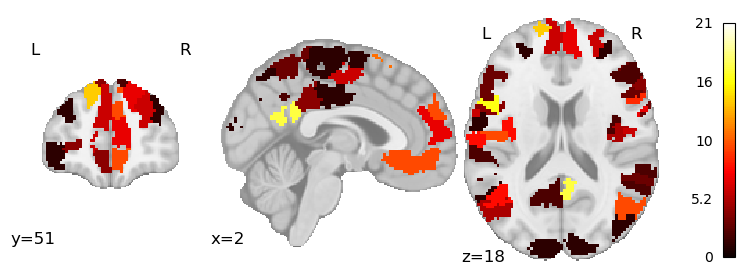

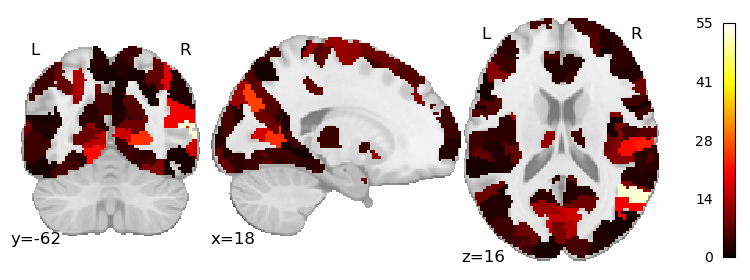

In [14]:
%%time
for contrast in NBS_constrasts.keys():
    for metric in ['Degree','Eigenvector_Centrality','Page_Rank']:
        # Create Empty Vector with same dimensions as atlas
        output_vector = np.zeros(atlas_vector.shape)
        # For each ROI extract the Graph Metric of interest
        for hm,nw,roi_name,roi_id,rgb in NBS_Gatts[contrast].index:
            output_vector[atlas_vector==roi_id] = NBS_Gatts[contrast].loc[(hm,nw,roi_name,roi_id,rgb),metric]
        # Write to disk just in case we want to look at it later
        output_img  = masking.unmask(output_vector,ns_dset_mask_path_RPI)
        output_path = osp.join(METAMAPS_RPI_DIR,f'{NBS_THRESHOLD}_{contrast}_{metric}.nii')
        output_img.to_filename(output_path)
        print('++ INFO: File written to disk [%s]' % output_path)
        if metric == 'Degree':
            plot_stat_map(output_path, draw_cross=False)

## 2.5. Also write file for the top degree ROI for each contrast (this is the one we will decode)

In [19]:
for contrast in NBS_constrasts.keys():
    input_path = osp.join(METAMAPS_RPI_DIR,f'{NBS_THRESHOLD}_{contrast}_Degree.nii')
    output_path = osp.join(METAMAPS_RPI_DIR,f'{NBS_THRESHOLD}_{contrast}_Degree_TopROI.nii')
    input_img  = load_img(input_path)
    top_degree_value = int(input_img.get_fdata().max())
    command = f'''module load afni; \
                  3dcalc -overwrite -a {input_path} -expr "equals(a,{top_degree_value})" -prefix {output_path}'''
    output  = subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
    print(output.strip().decode())

[+] Loading AFNI current-py3  ... 
AFNI/current-py3 last updated  2024-05-13

++ 3dcalc: AFNI version=AFNI_24.1.11 (May 10 2024) [64-bit]
++ Authored by: A cast of thousands
** AFNI converts NIFTI_datatype=64 (FLOAT64) in file /gpfs/gsfs11/users/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/LDA50/meta-analyses-RPI/NBS_3p1_f1GTf2_Degree.nii to FLOAT32
     Warnings of this type will be muted for this session.
     Set AFNI_NIFTI_TYPE_WARN to YES to see them all, NO to see none.
++ Output dataset /data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/LDA50/meta-analyses-RPI/NBS_3p1_f1GTf2_Degree_TopROI.nii
[+] Loading AFNI current-py3  ... 
AFNI/current-py3 last updated  2024-05-13

++ 3dcalc: AFNI version=AFNI_24.1.11 (May 10 2024) [64-bit]
++ Authored by: A cast of thousands
** AFNI converts NIFTI_datatype=64 (FLOAT64) in file /gpfs/gsfs11/users/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/

# 3. Preparations for WordCloud & ROI plot generation

Neurosynth topics and terms contain words that are not necessarily that meaningful when looking for relationships to cognitive processes. Examples of such words include those about anatomical structures, anatomical location, tissue types, imaging modalities, etc. We will remove those prior to generating wordclouds

In [24]:
my_stopwords = list(STOPWORDS) + ['resonance','magnetic','medial','lateral','dorsal','ventral','anterior','posterior','primary','secondary',
                                  'contralateral','prefrontal','temporal','occipital','parietal','frontal','network','cortex',
                                  'sii','mns','neuron','pre','md','gm','volume','matter','white','gray','hemispheric','state','mpfc','dmn','default',
                                  'fc','rest', 'temporoparietal','hippocampus','insula','premotor','supplementary','resting']

In this study we work with the 50 Topic dictionary. Each topic is associated with a set of terms that appear in unison in the neuroimaing literature. The next cell gathers the 40 top terms associated with each topic. We will only pick only those assoicated with topics that show significant correlations with our ROIs later when generating wordclouds. For now we load them all and have then ready on a pandas dataframe.

In [29]:
ns_dset_path         = osp.join(VOCAB_DIR, f"neurosynth_dataset_{VOCAB}.pkl.gz")
neurosynth_dset      = nimare_dataset.load(ns_dset_path)

In [32]:
path            = osp.join(VOCAB_DIR,'neurosynth',f'data-neurosynth_version-7_vocab-{VOCAB}_keys.tsv')
words_per_topic = pd.read_csv(path, sep='\t', header=None)
words_per_topic.index = neurosynth_dset.get_labels()
words_per_topic.index.name = 'Topic Label'
words_per_topic.columns = ['Topic ID','Unknown','Terms']
words_per_topic.head(5)

,Topic ID,Unknown,Terms
Topic Label,,,
LDA50_abstract_weight__0_network_state_resting,0,0.06871,network state resting default dmn mode intrins...
LDA50_abstract_weight__1_anxiety_trait_personality,1,0.02725,anxiety trait personality high scores individu...
LDA50_abstract_weight__2_cerebellar_cerebellum_basal,2,0.04606,cerebellar cerebellum basal ganglia thalamus m...
LDA50_abstract_weight__3_cortex_anterior_cingulate,3,0.08111,cortex anterior cingulate insula acc dorsal po...
LDA50_abstract_weight__4_stimulus_time_repetition,4,0.06010,stimulus time repetition priming response pres...


Finally, we will want to show the ROI with the highest degree on each direction of the contrast. To make nilearn plot the countour in black color, we need to generate a fake colormap with black being the first color.

In [38]:
roi_cmap = LinearSegmentedColormap.from_list('black',['#000000','#ffffff'],10)

# 4. ROI decoding on location with highest degree

## 4.1. Images-Pos-Others > Surr-Neg-Self

### 4.1.1. Load the target ROI

In [34]:
top_degree_roi_path =  osp.join(METAMAPS_RPI_DIR,f'{NBS_THRESHOLD}_f1GTf2_Degree_TopROI.nii')
top_degree_roi      = load_img(top_degree_roi_path)

/data/SFIMJGC_HCP7T/Apps/envs/fc_introspection_2023_py310/lib/python3.10/site-packages/nilearn/plotting/img_plotting.py:572: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  img = new_img_like(roi_img, data, affine=roi_img.affine)


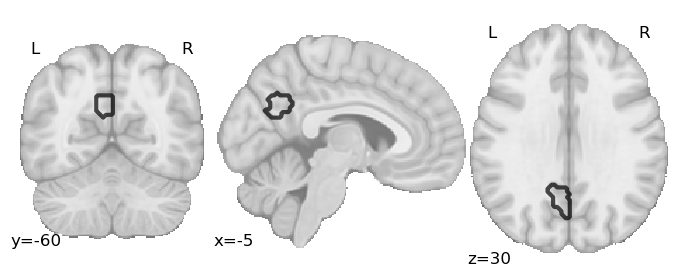

In [39]:
f = plot_roi(top_degree_roi,draw_cross=False, display_mode='ortho', linewidths=3, cut_coords=[-5,-60,30], view_type='contours', cmap=roi_cmap)

In [40]:
f.savefig('./figures/S15b_f1GTf2_TopDegree_ROI.png')

### 4.1.2. Gather the studies with coordinates that overlap with the ROI

In [41]:
# Get studies with voxels in the mask
ids = neurosynth_dset.get_studies_by_mask(top_degree_roi)
print('++INFO: Number of studies that overlap with the ROI: %d stduies' % len(ids))

++INFO: Number of studies that overlap with the ROI: 874 stduies


### 4.1.3. Decode using the Chi-Method

In [43]:
# Run the decoder
decoder = discrete.NeurosynthDecoder(u=0.05, correction='bonferroni')
decoder.fit(neurosynth_dset)
decoded_df = decoder.transform(ids=ids)

/data/SFIMJGC_HCP7T/Apps/envs/fc_introspection_2023_py310/lib/python3.10/site-packages/nimare/decode/discrete.py:600: RuntimeWarning: invalid value encountered in divide
  p_selected_g_noterm = n_selected_noterm / n_noterm


In [44]:
selected_topics = decoded_df[decoded_df['pReverse']<0.05].sort_values(by='probReverse', ascending=False)
print('++ List of topics that correlate significantly with the provided ROI (pBONF<0.05)')
selected_topics

++ List of topics that correlate significantly with the provided ROI (pBONF<0.05)


,pForward,zForward,probForward,pReverse,zReverse,probReverse
Term,,,,,,
LDA50_abstract_weight__8_mpfc_social_medial,1.000000e+00,-0.000000,0.078292,4.505484e-15,7.839999,0.653846
LDA50_abstract_weight__0_network_state_resting,9.122810e-34,12.112012,0.065256,1.099778e-09,6.094212,0.607735
LDA50_abstract_weight__28_social_empathy_moral,8.620917e-07,-4.920759,0.070471,3.328829e-03,2.935619,0.588736
LDA50_abstract_weight__33_memory_retrieval_encoding,1.253640e-12,7.099329,0.065425,2.184148e-05,4.245183,0.584648
LDA50_abstract_weight__21_matter_volume_structural,4.413011e-09,-5.867918,0.055158,2.551872e-02,-2.233459,0.418908
LDA50_abstract_weight__2_cerebellar_cerebellum_basal,1.453593e-12,-7.078847,0.054789,4.800654e-02,-1.977311,0.418546


### 4.1.4. Generate a wordcloud

If we are not dealing with terms directly, which is the case with the topic dictionaries, we need to first create a dictionary with the invidual terms assoicated with each topic.

That dictorionary will contain the term, and a weight that corresponds to the inverse rank of the term within the topic. As we consider only the top 40 terms associated with each topic (what Neurosynth makes available), weights will be integers in the range 1 to 40.

In [46]:
if VOCAB != 'terms':
    term_weights_per_topic={}
    for topic in words_per_topic.index:
        this_topic_words              = words_per_topic.loc[topic]['Terms']
        this_topic_words_top40        = this_topic_words.split(' ')[0:40][::-1]
        term_weights_per_topic[topic] = {word:weight+1 for weight,word in enumerate(this_topic_words_top40)}

Next, to generate final weights per term used in the wordcloud formation, we will multiply each term by the reverse probability of the topic to which they belong. Then for each term we will compute the final weight as the sum of all such topic specific weights (just in case a term appears in more than one selected topic.)

In [48]:
freqs_df = pd.Series(dtype=float)
if VOCAB == 'terms':
    for term_long,row in selected_topics.iterrows():
        term = term_long.split('__')[1]
        term_prob = row['probReverse']
        if term in freqs_df.index:
            freqs_df[term] = freqs_df[term] + term_prob
        else:
            freqs_df[term] = term_prob
else:
    for topic in selected_topics.index:
        this_topic_prob = selected_topics.loc[topic,'probReverse']
        for word,weight in term_weights_per_topic[topic].items():
            if word in freqs_df.index:
                freqs_df[word] = freqs_df[word] + (this_topic_prob * weight)
            else:
                freqs_df[word] = (this_topic_prob * weight)

Finally, we will select the top 30 terms for the wordcloud. Size of words will be directly related to the weights. In addition, to make sure color of the words is also associated with the weights, we need to do a bit more meddling so that we can crease a color scale that gives more emphasis (e.g., darker colors) to the terms with the highest weights, yet other words also have an intesnsity that allows us to read the words.

In [49]:
freqs_df.drop(my_stopwords,errors='ignore', inplace=True)
freqs_df  = freqs_df.sort_values(ascending=False)[0:30]

In [52]:
# Compute values constrained between 0 and 100 (ONLY FOR COLORSCALE PURPOSES)
freqs_arr = freqs_df.values
freqs_arr = freqs_arr.reshape(-1,1)
freqs_arr = MinMaxScaler((25,99)).fit_transform(freqs_arr)
freqs_df_color = pd.Series(freqs_arr.flatten(),index=freqs_df.index)

As the wordcloud API takes as inputs dictonaries, we will transform the dataframes with the weights for word_size and word_color to python dictionary structures

In [53]:
freqs_dict = freqs_df.to_dict()
freqs_color_dict = freqs_df_color.to_dict()

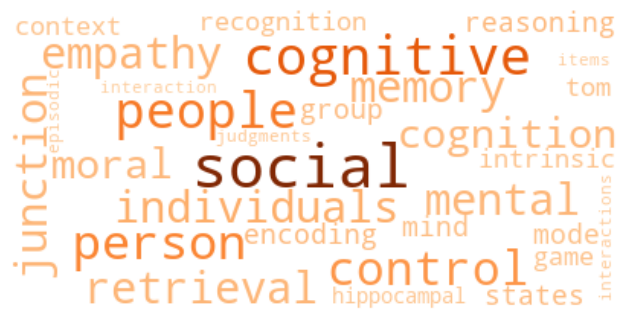

In [60]:
wc = WordCloud(max_font_size=40,min_font_size=9, stopwords=set(my_stopwords),
                   contour_color='black', contour_width=3, 
                   background_color='white', color_func=my_orange_color_func(freqs_color_dict),
                   repeat=False).generate_from_frequencies(freqs_dict )
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.savefig(f'./figures/S15b_WordCloud_{NBS_THRESHOLD}_f1GTf2_TopDegree_NeuosynthDeconding.png')

## 4.2. Surr-Neg-Self > Images-Pos-Others

### 4.2.1. Load the target ROI

In [63]:
top_degree_roi_path =  osp.join(METAMAPS_RPI_DIR,f'{NBS_THRESHOLD}_f2GTf1_Degree_TopROI.nii')
top_degree_roi      = load_img(top_degree_roi_path)

/data/SFIMJGC_HCP7T/Apps/envs/fc_introspection_2023_py310/lib/python3.10/site-packages/nilearn/plotting/img_plotting.py:572: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  img = new_img_like(roi_img, data, affine=roi_img.affine)


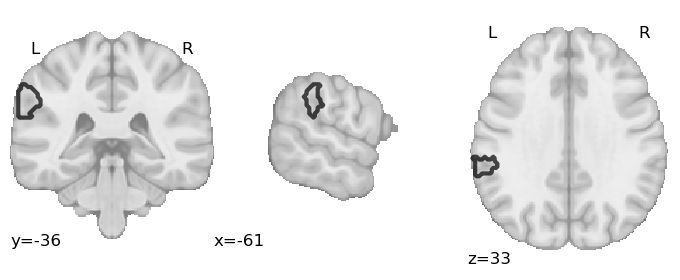

In [64]:
f = plot_roi(top_degree_roi,draw_cross=False, display_mode='ortho', linewidths=3, cut_coords=[-61,-36,33], view_type='contours', cmap=roi_cmap)

In [65]:
f.savefig(f'./figures/S15b_{NBS_THRESHOLD}_f2GTf1_TopDegree_ROI.png')

### 4.2.2. Gather the studies with coordinates that overlap with the ROI

In [66]:
# Get studies with voxels in the mask
ids = neurosynth_dset.get_studies_by_mask(top_degree_roi)
print('++INFO: Number of studies that overlap with the ROI: %d stduies' % len(ids))

++INFO: Number of studies that overlap with the ROI: 558 stduies


### 4.2.3. Decode using the Chi-Method

In [67]:
# Run the decoder
decoder = discrete.NeurosynthDecoder(u=0.05, correction='bonferroni')
decoder.fit(neurosynth_dset)
decoded_df = decoder.transform(ids=ids)

In [68]:
selected_topics = decoded_df[decoded_df['pReverse']<0.05].sort_values(by='probReverse', ascending=False)
print('++ List of topics that correlate significantly with the provided ROI (pBONF<0.05)')
selected_topics

++ List of topics that correlate significantly with the provided ROI (pBONF<0.05)


,pForward,zForward,probForward,pReverse,zReverse,probReverse
Term,,,,,,
LDA50_abstract_weight__32_pain_somatosensory_stimulation,3.210047e-03,-2.946873,0.052576,1.554981e-07,5.245927,0.659187
LDA50_abstract_weight__19_action_actions_observation,2.868383e-01,-1.065083,0.047193,3.564569e-04,3.570385,0.617175
LDA50_abstract_weight__21_matter_volume_structural,2.545915e-07,-5.154292,0.033617,3.760127e-03,-2.897614,0.377471


### 4.2.4. Generate a wordcloud

If we are not dealing with terms directly, which is the case with the topic dictionaries, we need to first create a dictionary with the invidual terms assoicated with each topic.

That dictorionary will contain the term, and a weight that corresponds to the inverse rank of the term within the topic. As we consider only the top 40 terms associated with each topic (what Neurosynth makes available), weights will be integers in the range 1 to 40.

In [70]:
if VOCAB != 'terms':
    term_weights_per_topic={}
    for topic in words_per_topic.index:
        this_topic_words              = words_per_topic.loc[topic]['Terms']
        this_topic_words_top40        = this_topic_words.split(' ')[0:40][::-1]
        term_weights_per_topic[topic] = {word:weight+1 for weight,word in enumerate(this_topic_words_top40)}

Next, to generate final weights per term used in the wordcloud formation, we will multiply each term by the reverse probability of the topic to which they belong. Then for each term we will compute the final weight as the sum of all such topic specific weights (just in case a term appears in more than one selected topic.)

In [71]:
freqs_df = pd.Series(dtype=float)
if VOCAB == 'terms':
    for term_long,row in selected_topics.iterrows():
        term = term_long.split('__')[1]
        term_prob = row['probReverse']
        if term in freqs_df.index:
            freqs_df[term] = freqs_df[term] + term_prob
        else:
            freqs_df[term] = term_prob
else:
    for topic in selected_topics.index:
        this_topic_prob = selected_topics.loc[topic,'probReverse']
        for word,weight in term_weights_per_topic[topic].items():
            if word in freqs_df.index:
                freqs_df[word] = freqs_df[word] + (this_topic_prob * weight)
            else:
                freqs_df[word] = (this_topic_prob * weight)

Finally, we will select the top 30 terms for the wordcloud. Size of words will be directly related to the weights. In addition, to make sure color of the words is also associated with the weights, we need to do a bit more meddling so that we can crease a color scale that gives more emphasis (e.g., darker colors) to the terms with the highest weights, yet other words also have an intesnsity that allows us to read the words.

In [72]:
freqs_df.drop(my_stopwords,errors='ignore', inplace=True)
freqs_df  = freqs_df.sort_values(ascending=False)[0:30]

In [73]:
# Compute values constrained between 0 and 100 (ONLY FOR COLORSCALE PURPOSES)
freqs_arr = freqs_df.values
freqs_arr = freqs_arr.reshape(-1,1)
freqs_arr = MinMaxScaler((25,99)).fit_transform(freqs_arr)
freqs_df_color = pd.Series(freqs_arr.flatten(),index=freqs_df.index)

As the wordcloud API takes as inputs dictonaries, we will transform the dataframes with the weights for word_size and word_color to python dictionary structures

In [74]:
freqs_dict = freqs_df.to_dict()
freqs_color_dict = freqs_df_color.to_dict()

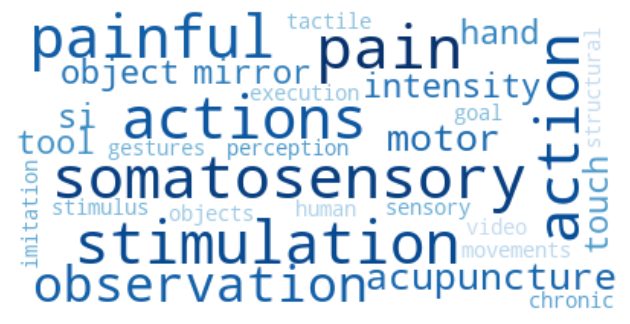

In [76]:
wc = WordCloud(max_font_size=40,min_font_size=9, stopwords=set(my_stopwords),
                   contour_color='black', contour_width=3, 
                   background_color='white', color_func=my_blue_color_func(freqs_color_dict),
                   repeat=False).generate_from_frequencies(freqs_dict )
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.savefig(f'./figures/S15b_WordCloud_{NBS_THRESHOLD}_f2GTf1_TopDegree_NeuosynthDeconding.png')